# Homework - Neural networks - Part B (45 points)
## Gradient descent for simple two and three layer models

by *Brenden Lake* and *Todd Gureckis*  
Computational Cognitive Modeling  
NYU class webpage: https://brendenlake.github.io/CCM-site/  

<div class="alert alert-danger" role="alert">
This homework is due before midnight on Monday, Feb. 22, 2021.
</div>

The first part of this assignment implements the gradient descent algorithm for a simple artificial neuron. The second part implements backpropagation for a simple network with one hidden unit.

In the first part, the neuron will learn to compute logical OR. The neuron model and logical OR are shown below, for inputs $x_0$ and $x_1$ and target output $y$.

<img src="images/nn_OR.jpeg" style="width: 350px;"/>

This assignment requires some basic PyTorch knowledge. You can review your notes from lab and also two basic [PyTorch tutorials](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html), "What is PyTorch?" and "Autograd", which should have the basics you need.

In [2]:
# Import libraries
from __future__ import print_function
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

Let's create `torch.tensor` objects for representing the data matrix `D` with targets `Y_or` (for the logical OR function). Each row of `D` is a different data point.

In [3]:
# Data
D = np.zeros((4,2),dtype=float)
D[0,:] = [0.,0.]
D[1,:] = [0.,1.]
D[2,:] = [1.,0.]
D[3,:] = [1.,1.]
D = torch.tensor(D,dtype=torch.float)
Y_or = torch.tensor([0.,1.,1.,1.])
N = D.shape[0] # number of input patterns

The artificial neuron operates as follows. Given an input vector $x$, the net input ($\textbf{net}$) to the neuron is computed as follows

$$ \textbf{net} = \sum_i x_i w_i + b,$$

for weights $w_i$ and bias $b$. The activation function $g(\textbf{net})$ is the logistic function

$$ g(\textbf{net}) = \frac{1}{1+e^{-\textbf{net}}},$$

which is used to compute the predicted output $\hat{y} = g(\textbf{net})$. Finally, the loss (squared error) for a particular pattern $x$ is defined as 

$$ E(w,b) = (\hat{y}-y)^2,$$

where the target output is $y$. **Your main task is to manually compute the gradients of the loss $E$ with respect to the neuron parameters:**

$$\frac{\partial E(w,b)}{\partial w}, \frac{\partial E(w,b)}{\partial b}.$$

By manually, we mean to program the gradient computation directly, using the formulas discussed in class. This is in contrast to using PyTorch's `autograd` (Automatric differentiation) that computes the gradient automatically, as discussed in class, lab, and in the PyTorch tutorial (e.g., `loss.backward()`). First, let's write the activation function and the loss in PyTorch. 

In [4]:
def g_logistic(net):
    return 1. / (1.+torch.exp(-net))

def loss(yhat,y):
    return (yhat-y)**2

Next, we'll also write two functions for examining the internal operations of the neuron, and the gradients of its parameters.

In [5]:
def print_forward(x,yhat,y):
    # Examine network's prediction for input x
    print(' Input: ',end='')
    print(x.numpy())
    print(' Output: ' + str(round(yhat.item(),3)))
    print(' Target: ' + str(y.item()))

def print_grad(grad_w,grad_b):
    # Examine gradients
    print('  d_loss / d_w = ',end='')
    print(grad_w)
    print('  d_loss / d_b = ',end='')
    print(grad_b)

Now let's dive in and begin the implementation of stochastic gradient descent. We'll initialize our parameters $w$ and $b$ randomly, and proceed through a series of epochs of training. Each epoch involves visiting the four training patterns in random order, and updating the parameters after each presentation of an input pattern.



<div class="alert alert-success" role="alert">
<h3> Problem 1 (10 points) </h3>
<br>
In the code below, fill in code to manually compute the gradient in closed form.
    <ul>
        <li>See lecture slides for the equation for the gradient for the weights w.</li>
        <li>Derive (or reason) to get the equation for the gradient for bias b.</li>
    </ul>
</div>

<div class="alert alert-success" role="alert">
<h3> Problem 2 (5 points) </h3>
<br>
In the code below, fill in code for the weight and bias update rule for gradient descent.
</div>

After completing the code, run it to compare **your gradients** with the **ground-truth computed by PyTorch.** (There may be small differences that you shouldn't worry about, e.g. within 1e-6). Also, you can check the neuron's performance at the end of training.

Compute the gradient manually
 Input: [0. 0.]
 Output: 0.63
 Target: 0.0
  d_loss / d_w = [0. 0.]
  d_loss / d_b = [0.29371554]
Compute the gradient using PyTorch .backward()
  d_loss / d_w = [0. 0.]
  d_loss / d_b = [0.29371554]

Compute the gradient manually
 Input: [1. 0.]
 Output: 0.754
 Target: 1.0
  d_loss / d_w = [-0.09147369 -0.        ]
  d_loss / d_b = [-0.09147369]
Compute the gradient using PyTorch .backward()
  d_loss / d_w = [-0.09147366  0.        ]
  d_loss / d_b = [-0.09147366]

Compute the gradient manually
 Input: [0. 1.]
 Output: 0.477
 Target: 1.0
  d_loss / d_w = [-0.        -0.2611509]
  d_loss / d_b = [-0.2611509]
Compute the gradient using PyTorch .backward()
  d_loss / d_w = [ 0.         -0.26115093]
  d_loss / d_b = [-0.26115093]

Compute the gradient manually
 Input: [1. 1.]
 Output: 0.631
 Target: 1.0
  d_loss / d_w = [-0.17173384 -0.17173384]
  d_loss / d_b = [-0.17173384]
Compute the gradient using PyTorch .backward()
  d_loss / d_w = [-0.17173381 -0.1717

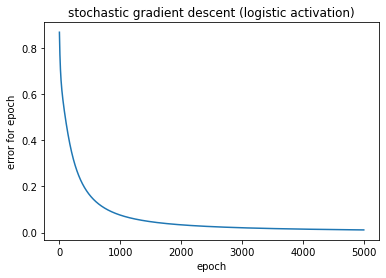

In [6]:
# Initialize parameters
#     Although you will implement gradient descent manually, let's set requires_grad=True
#     anyway so PyTorch will track the gradient too, and we can compare your gradient with PyTorch's.
w = torch.randn(2) # [size 2] tensor
b = torch.randn(1) # [size 1] tensor
w.requires_grad = True
b.requires_grad = True

alpha = 0.05 # learning rate
nepochs = 5000 # number of epochs

track_error = []
verbose = True
for e in range(nepochs): # for each epoch
    error_epoch = 0. # sum loss across the epoch
    perm = np.random.permutation(N)
    for p in perm: # visit data points in random order
        x = D[p,:] # input pattern
        
        # compute output of neuron
        net = torch.dot(x,w)+b
        yhat = g_logistic(net)
        
        # compute loss
        y = Y_or[p]
        myloss = loss(yhat,y)
        error_epoch += myloss.item()
        
        # print output if this is the last epoch
        if (e == nepochs-1):
            print("Final result:")
            print_forward(x,yhat,y)
            print("")

        # Compute the gradient manually
        if verbose:
            print('Compute the gradient manually')
            print_forward(x,yhat,y)
        with torch.no_grad():
            # TODO : YOUR GRADIENT CODE GOES HERE
            #  two lines of the form
            w_grad = 2*(yhat - y)*yhat*(1-yhat)*x    #([size 2] PyTorch tensor)
            b_grad = 2*(yhat-y)*yhat*(1-yhat)    #([size 1] PyTorch tensor)
            #  make sure to inclose your code in the "with torch.no_grad()" wrapper,
            #   otherwise PyTorch will try to track the "gradient" of the gradient computation, which we don't want.         
            # raise Exception('Replace with your code.')                      
        if verbose: print_grad(w_grad.numpy(),b_grad.numpy())

        # Compute the gradient with PyTorch and compre with manual values
        if verbose: print('Compute the gradient using PyTorch .backward()')
        myloss.backward()
        if verbose:
            print_grad(w.grad.numpy(),b.grad.numpy())
            print("")
        w.grad.zero_() # clear PyTorch's gradient
        b.grad.zero_()
        
        # Parameter update with gradient descent
        with torch.no_grad():
            # TODO : YOUR PARAMETER UPDATE CODE GOES HERE
            #  two lines of the form:
            w -= alpha * w_grad
            b -= alpha * b_grad
            #raise Exception('Replace with your code.')
            
    if verbose==True: verbose=False
    track_error.append(error_epoch)
    if e % 50 == 0:
        print("epoch " + str(e) + "; error=" +str(round(error_epoch,3)))
    
# track output of gradient descent
plt.figure()
plt.clf()
plt.plot(track_error)
plt.title('stochastic gradient descent (logistic activation)')
plt.ylabel('error for epoch')
plt.xlabel('epoch')
plt.show()

Now let's change the activation function to "tanh" from the "logistic" function, such that $g(\textbf{net}) = \tanh(\textbf{net})$. Here is an implementation of tanh.

In [7]:
def g_tanh(x):
    return (torch.exp(x) - torch.exp(-x))/(torch.exp(x) + torch.exp(-x))


The derivative of the tanh function is as follows:

$$\frac{\partial g(\textbf{net})}{\partial \textbf{net}}= \frac{\partial \tanh(\textbf{net})}{\partial \textbf{net}} = 1.0 - (\tanh(\textbf{net}))^2$$

<div class="alert alert-success" role="alert">
<h3> Problem 3 (5 points) </h3>
<br>
Just as before, fill in the missing code fragments for implementing gradient descent. This time we are using the tanh activation function. Be sure to change your gradient calculation to reflect the new activation function.
</div>

Compute the gradient manually
 Input: [0. 0.]
 Output: -0.146
 Target: 0.0
  d_loss / d_w = [-0. -0.]
  d_loss / d_b = [-0.28637198]
Compute the gradient using PyTorch .backward()
  d_loss / d_w = [-0. -0.]
  d_loss / d_b = [-0.286372]

Compute the gradient manually
 Input: [0. 1.]
 Output: 0.987
 Target: 1.0
  d_loss / d_w = [-0.        -0.0007168]
  d_loss / d_b = [-0.0007168]
Compute the gradient using PyTorch .backward()
  d_loss / d_w = [ 0.        -0.0007168]
  d_loss / d_b = [-0.0007168]

Compute the gradient manually
 Input: [1. 1.]
 Output: 0.958
 Target: 1.0
  d_loss / d_w = [-0.00702034 -0.00702034]
  d_loss / d_b = [-0.00702034]
Compute the gradient using PyTorch .backward()
  d_loss / d_w = [-0.00702033 -0.00702033]
  d_loss / d_b = [-0.00702033]

Compute the gradient manually
 Input: [1. 0.]
 Output: -0.613
 Target: 1.0
  d_loss / d_w = [-2.0135736 -0.       ]
  d_loss / d_b = [-2.0135736]
Compute the gradient using PyTorch .backward()
  d_loss / d_w = [-2.0135736  0.    

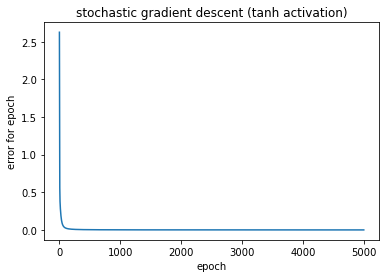

In [8]:
# Initialize parameters
#     Although you will implement gradient descent manually, let's set requires_grad=True
#     anyway so PyTorch will track the gradient too, and we can compare your gradient with PyTorch's.
w = torch.randn(2) # [size 2] tensor
b = torch.randn(1) # [size 1] tensor
w.requires_grad = True
b.requires_grad = True

alpha = 0.05 # learning rate
nepochs = 5000 # number of epochs

track_error = []
verbose = True
for e in range(nepochs): # for each epoch
    error_epoch = 0. # sum loss across the epoch
    perm = np.random.permutation(N)
    for p in perm: # visit data points in random order
        x = D[p,:] # input pattern
        
        # compute output of neuron
        net = torch.dot(x,w)+b
        yhat = g_tanh(net)
        
        # compute loss
        y = Y_or[p]
        myloss = loss(yhat,y)
        error_epoch += myloss.item()
        
        # print output if this is the last epoch
        if (e == nepochs-1):
            print("Final result:")
            print_forward(x,yhat,y)
            print("")

        # Compute the gradient manually
        if verbose:
            print('Compute the gradient manually')
            print_forward(x,yhat,y)
        with torch.no_grad():
            # TODO : YOUR GRADIENT CODE GOES HERE
            #  two lines of the form
            w_grad = 2*(yhat - y)*(1-(yhat)**2)*x    # ([size 2] PyTorch tensor)
            b_grad = 2*(yhat - y)*(1-(yhat)**2)  # ([size 1] PyTorch tensor)
            #  make sure to inclose your code in the "with torch.no_grad()" wrapper,
            #   otherwise PyTorch will try to track the "gradient" of the graident computation, which we don't want.
            #raise Exception('Replace with your code.')                       
        if verbose: print_grad(w_grad.numpy(),b_grad.numpy())

        # Compute the gradient with PyTorch and compre with manual values
        if verbose: print('Compute the gradient using PyTorch .backward()')
        myloss.backward()
        if verbose:
            print_grad(w.grad.numpy(),b.grad.numpy())
            print("")
        w.grad.zero_() # clear PyTorch's gradient
        b.grad.zero_()
        
        # Parameter update with gradient descent
        with torch.no_grad():
            # TODO : YOUR PARAMETER UPDATE CODE GOES HERE
            #  two lines of the form:
            w -= w_grad*alpha
            b -= b_grad*alpha
            # raise Exception('Replace with your code.')
            
    if verbose==True: verbose=False
    track_error.append(error_epoch)
    if e % 50 == 0:
        print("epoch " + str(e) + "; error=" +str(round(error_epoch,3)))
    
# track output of gradient descent
plt.figure()
plt.clf()
plt.plot(track_error)
plt.title('stochastic gradient descent (tanh activation)')
plt.ylabel('error for epoch')
plt.xlabel('epoch')
plt.show()

In the next part, we have a simple multi-layer network with two input neurons, one hidden neuron, and one output neuron. Both the hidden and output unit should use the logistic activation function. We will learn to compute logical XOR. The network and logical XOR are shown below, for inputs $x_0$ and $x_1$ and target output $y$.

<img src="images/nn_XOR.jpeg" style="width: 500px;"/>

<div class="alert alert-success" role="alert">
<h3> Problem 4 (15 points) </h3>
<br>
You will implement backpropagation for this simple network. In the code below, you have several parts to fill in. First, define the forward pass to compute the output `yhat` from the input `x`. Second, fill in code to manually compute the gradients for all five weights w and two biases b in closed form. Third, fill in the code for updating the biases and weights.
</div>

After completing the code, run it to compare **your gradients** with the **ground-truth computed by PyTorch.** (There may be small differences that you shouldn't worry about, e.g. within 1e-6). Also, you can check the network's performance at the end of training.

x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
Compute the gradient manually
 Input: [1. 1.]
 Output: 0.99
 Target: 0.0
 Grad for w_34 and b_0
  d_loss / d_w = [0.00852944 0.00852944]
  d_loss / d_b = [0.00852944]
 Grad for w_012 and b_1
  d_loss / d_w = [ 0.01886818  0.01886818 -0.01616435]
  d_loss / d_b = [0.01886818]

Compute the gradient using PyTorch .backward()
 Grad for w_34 and b_0
  d_loss / d_w = [-0.00286732 -0.00286732]
  d_loss / d_b = [-0.00286732]
 Grad for w_012 and b_1
  d_loss / d_w = [ 0.03791964  0.03791964 -0.03248571]
  d_loss / d_b = [0.03791964]

x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
Compute the gradient manually
 Input: [0. 0.]
 Output: 0.199
 Target: 0.0
 Grad for w_34 and b_0
  d_loss / d_w = [0. 0.]
  d_loss / d_b = [0.03277125]
 Grad for w_012 and b_1
  d_loss / d_w = [ 0.          0.         -0.05951074

x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.425

tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
epoch 50; error=1.048
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  

x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.425

x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.425

x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.425

x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.425

x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.425

tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requ

tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requ

epoch 250; error=1.048
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.]

x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.425

x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.425

tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requ

x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.425

x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.425

x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.425

x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.425

tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requ

x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.425

x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.425

x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.425

tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requ

tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requ

x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.425

x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.425

tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requ

x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.425

x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.425

x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.425

tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requ

tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=T

x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.425

tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=T

tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=T

x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.425

x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.425

x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.425

tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requ

tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requ

x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.425

x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.425

tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requ

x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.425

x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.425

x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.425

x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.425

x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.425

x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.425

x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.425

x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
epoch 1100; error=1.048
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.

tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requ

tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=T

x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.425

x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.425

tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=T

x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.425

x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.425

x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.425

tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=T

x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.425

tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requ

x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.425

x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.425

tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=T

tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=T

x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.425

tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=T

x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.425

tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=T

x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.425

x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.425

tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
epoch 1600; error=1.048
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,

x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.425

x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.425

x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.425

x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.425

tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=T

x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.425

tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
epoch 1750; error=1.048
x tensor([0., 1.])
tensor([0.0119, 

tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=T

x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.425

x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.425

x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.425

x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.425

tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requ

x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.425

x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
epoch 1950; error=1.048
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.

tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=T

x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.425

tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requ

tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requ

x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.425

x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.425

x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.425

x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.425

tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=T

x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.425

tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=T

tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=T

tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requ

tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requ

x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.425

x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.425

x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.425

x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.425

x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.425

x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.425

x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.425

tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=T

x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.425

tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requ

tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requ

x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.425

x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.425

tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requ

x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.425

tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=T

x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.425

tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requ

tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=T

x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.425

tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requ

tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requ

x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.425

x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.425

x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.425

x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.425

tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=T

epoch 3050; error=1.048
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.

x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.425

x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.425

x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.425

x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.425

x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.425

tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requ

x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.425

tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=T

x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.425

x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.425

x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.425

x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.425

x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.425

tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requ

tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=T

x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.425

tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requ

x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.425

x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.425

tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requ

tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=T

x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.425

x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.425

x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.425

x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.425

x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.425

x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
epoch 3650; error=1.048
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.

x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.425

x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.425

x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
epoch 3750; error=1.048
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.

tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=T

tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requ

tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requ

x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.425

x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.425

x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.425

x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.425

x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.425

x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.425

tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=T

x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.425

x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.425

tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requ

x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.425

x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.425

x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.425

tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requ

tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=T

x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.425

x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.425

x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.425

tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requ

x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.425

x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.425

x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.425

x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.425

x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.425

tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requ

x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.425

tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requ

tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requ

x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.425

tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
epoch 4450; error=1.048
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,

x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.425

x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.425

x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.425

x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.425

tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requ

tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requ

x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.425

tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requ

tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=T

x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
epoch 4650; error=1.048
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.

x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.425

x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.425

x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.425

tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requ

x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.425

x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.425

x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.425

x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.425

tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requ

x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.425

tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requ

tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=T

x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.425

x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.425

x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.425

x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.425

x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.425

x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.425

x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.425

x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.425

tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requ

x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.425

tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=T

x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.425

tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requ

tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=T

tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=T

tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=T

tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requ

x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.425

tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=T

tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=T

x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.425

x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.425

tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=T

x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
epoch 5400; error=1.048
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.

x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.425

tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=T

tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=T

x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.425

tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requ

tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requ

x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.425

x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.425

x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.425

x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.425

x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
epoch 5650; error=1.048
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.

x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.425

x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.425

tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=T

tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=T

x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.425

x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.425

x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
epoch 5800; error=1.048
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.

x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.425

tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=T

x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.425

tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=T

x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.425

x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.425

x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.425

x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.425

x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.425

tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=T

tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requ

x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.425

x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.425

x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.425

tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=T

x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.425

x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.425

x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.425

tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requ

x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.425

tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requ

x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.425

x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.425

x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.425

x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.425

x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.425

x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.425

x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.425

x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.425

x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.425

tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=T

x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.425

tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requ

tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requ

tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requ

x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.425

tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requ

tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requ

tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=T

tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requ

x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.425

x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.425

x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.425

tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=T

x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.425

x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.425

x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.425

x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.425

x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.425

x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.425

x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.425

tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=T

tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=T

x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.425

x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.425

tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requ

x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.425

x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.425

x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.425

tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=T

x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.425

tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requ

x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.425

x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.425

tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requ

tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requ

x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.425

x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.425

x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.425

tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requ

x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.425

x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.425

tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=T

tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requ

x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.425

tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=T

x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.425

tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=T

tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=T

tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=T

tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requ

x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.425

tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=T

x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.425

x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
epoch 7750; error=1.048
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.

x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.425

x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.425

tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=T

x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.425

x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.425

tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=T

x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.425

tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=T

x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.425

x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.425

tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([1., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 0.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requires_grad=True)
x tensor([0., 1.])
tensor([0.0119, 0.4256], requires_grad=True)
tensor([ 1.0653,  1.4222, -0.2842], requ

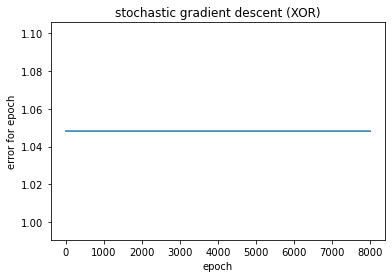

In [29]:
# New data D and labels y for xor
D = np.zeros((4,2),dtype=float)
D[0,:] = [0.,0.]
D[1,:] = [0.,1.]
D[2,:] = [1.,0.]
D[3,:] = [1.,1.]
D = torch.tensor(D,dtype=torch.float)
Y_xor = torch.tensor([0.,1.,1.,0.])
N = D.shape[0] # number of input patterns

# Initialize parameters
#     Although you will implement gradient descent manually, let's set requires_grad=True
#     anyway so PyTorch will track the gradient too, and we can compare your gradient with PyTorch's.
w_34 = torch.randn(2) # [size 2] tensor representing [w_3,w_4]
w_012 = torch.randn(3) # [size 3] tensor representing [w_0,w_1,w_2]
b_0 = torch.randn(1) # [size 1] tensor
b_1 = torch.randn(1) # [size 1] tensor
w_34.requires_grad=True
w_012.requires_grad=True
b_0.requires_grad=True
b_1.requires_grad=True

alpha = 0.05 # learning rate
nepochs = 8000 # number of epochs

track_error = []
verbose = True
for e in range(nepochs): # for each epoch
    error_epoch = 0. # sum loss across the epoch
    perm = np.random.permutation(N)
    for p in perm: # visit data points in random order
        x = D[p,:] # input pattern
        print("x", x)
        print(w_34)
        print(w_012)
        # Compute the output of hidden neuron h
        # e.g., two lines like the following
        #  net_h = ...
        #  h = ...
        net_h = torch.dot(x,w_34)+b_0
        h = g_tanh(net_h)
        # TODO : YOUR CODE GOES HERE
        # raise Exception('Replace with your code.')                  
        # Compute the output of neuron yhat
        # e.g., two lines like the following
        #  net_y = ...
        #  yhat = ...
        xh = torch.torch.cat((x,h),0)
        #print("both", both)
        net_y = torch.dot(xh,w_012)+b_1
        yhat = g_tanh(net_y)
        # TODO : YOUR CODE GOES HERE
        # raise Exception('Replace with your code.')                     
        
        # compute loss
        y = Y_xor[p]
        myloss = loss(yhat,y)
        error_epoch += myloss.item()
        
        # print output if this is the last epoch
        if (e == nepochs-1):
            print("Final result:")
            print_forward(x,yhat,y)
            print("")

        # Compute the gradient manually
        if verbose:
            print('Compute the gradient manually')
            print_forward(x,yhat,y)
        with torch.no_grad():
            # TODO : YOUR GRADIENT CODE GOES HERE
            #  should include at least these 4 lines (helper lines may be useful)
            w_34_grad = 2*(yhat-y)*yhat*(1-yhat)*w_012[2]*(h*(1-h)*x)
            b_0_grad = 2*(yhat-y)*yhat*(1-yhat)*w_012[2]*(h*(1-h))
            w_012_grad = 2*(yhat-y)*yhat*(1-yhat)*torch.cat((x,h),0)
            b_1_grad = (2*(yhat-y)*yhat*(1-yhat))
            #  make sure to inclose your code in the "with torch.no_grad()" wrapper,
            #   otherwise PyTorch will try to track the "gradient" of the gradient computation, which we don't want.
            # raise Exception('Replace with your code.')                      
        if verbose:
            print(" Grad for w_34 and b_0")
            print_grad(w_34_grad.numpy(),b_0_grad.numpy())
            print(" Grad for w_012 and b_1")
            print_grad(w_012_grad.numpy(),b_1_grad.numpy())
            print("")

        # Compute the gradient with PyTorch and compre with manual values
        if verbose: print('Compute the gradient using PyTorch .backward()')
        myloss.backward()
        if verbose:
            print(" Grad for w_34 and b_0")
            print_grad(w_34.grad.numpy(),b_0.grad.numpy())
            print(" Grad for w_012 and b_1")
            print_grad(w_012.grad.numpy(),b_1.grad.numpy())
            print("")
        w_34.grad.zero_() # clear PyTorch's gradient
        b_0.grad.zero_()
        w_012.grad.zero_()
        b_1.grad.zero_()
        
        # Parameter update with gradient descent
        with torch.no_grad():
            # TODO : YOUR PARAMETER UPDATE CODE GOES HERE
            # Four lines of the form
            w_34 -= w_34.grad * alpha
            b_0 -= b_0.grad * alpha
            w_012 -= w_012.grad * alpha
            b_1 -= b_1.grad * alpha
            #raise Exception('Replace with your code.')
            
    if verbose==True: verbose=False
    track_error.append(error_epoch)
    if e % 50 == 0:
        print("epoch " + str(e) + "; error=" +str(round(error_epoch,3)))
    
# track output of gradient descent
plt.figure()
plt.clf()
plt.plot(track_error)
plt.title('stochastic gradient descent (XOR)')
plt.ylabel('error for epoch')
plt.xlabel('epoch')
plt.show()


<div class="alert alert-success" role="alert">
<h3> Problem 5 (10 points) </h3>
<br>
After running your XOR network, print the values of the learned weights and biases. Your job now is to describe the solution that the network has learned. How does it work? Walk through each input pattern to describe how the network computes the right answer (if it does). See discussion in lecture for an example.
</div>

The XOR network uses two hidden nodes and one output node. The error remains the same throughout the 8000 epochs. If the input is either {0,0} or {1,1} the XOR should output 0. If the input is {0,1} or {1,0}, the output should be 1. It computes three of the combinations correctly, but tends to mis-compute the tensor {1,1}. It suggests an output of 0.99, when the target output is 0.0.
